## 1. Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from catboost import CatBoostClassifier

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

print("✅ Imports loaded")

c:\Users\mattr\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✅ Imports loaded


In [2]:
# ==================== TRADING PARAMETERS ====================

# Committee Scoring Thresholds
ML_MODEL_PROB_THRESHOLD = 0.51     # ML model probability > this to get 2 points
ADX_THRESHOLD = 35                 # ADX > this to get 1 point (trend strength)
RSI_LOWER_BOUND = 50               # RSI lower bound for momentum
RSI_UPPER_BOUND = 75               # RSI upper bound for momentum
L2_IMBALANCE_RATIO = 1.3           # Top 10 Pressure: Bid/Ask ratio > 1.2 = 20% buying pressure
COMMITTEE_SCORE_THRESHOLD = 4      # Minimum committee score to enter trade (max 6)

# Risk Management
TAKE_PROFIT_PCT = 0.015            # Take profit at +1.5%
STOP_LOSS_PCT = 0.01               # Stop loss at -1.0%
FEE_PCT = 0.0008                   # Trading fee 0.08% per side

# Position Sizing
TRADE_SIZE_PCT = 0.95              # Use 95% of capital per trade
COOLDOWN_MINUTES = 5               # Wait 5 minutes after opening trade

# Capital
INITIAL_CAPITAL = 10000            # Starting capital in USD

print("✅ Trading parameters configured")
print(f"   Committee threshold: {COMMITTEE_SCORE_THRESHOLD} points")
print(f"   Risk/Reward: +{TAKE_PROFIT_PCT*100:.1f}% / -{STOP_LOSS_PCT*100:.1f}%")

✅ Trading parameters configured
   Committee threshold: 4 points
   Risk/Reward: +1.5% / -1.0%


## 1.5. Trading Configuration

Global parameters for strategy tuning:

## 2. Feature Engineering

Generate trading features matching the Golden Trio notebook:
- **ETH** (Target Asset): Returns, Volatility, RSI, ADX, VWAP
- **BTC** (Beta Asset): Returns, Volatility, Price-to-MA ratios
- **Market Index** (15 Assets): Equal-weighted returns and volatility

In [3]:
class FeatureEngine:
    """Generate trading features matching the Golden Trio notebook"""
    
    @staticmethod
    def compute_rsi(series, period=14):
        """Compute RSI indicator"""
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

print("✅ RSI method defined")

✅ RSI method defined


In [4]:
def compute_adx(high, low, close, period=14):
    """Compute ADX (Average Directional Index) indicator"""
    # True Range
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # Directional Movement
    up_move = high - high.shift(1)
    down_move = low.shift(1) - low
    
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
    
    # Smoothed indicators
    atr = tr.rolling(window=period).mean()
    plus_di = 100 * pd.Series(plus_dm).rolling(window=period).mean() / atr
    minus_di = 100 * pd.Series(minus_dm).rolling(window=period).mean() / atr
    
    # ADX
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.rolling(window=period).mean()
    
    return adx

FeatureEngine.compute_adx = staticmethod(compute_adx)
print("✅ ADX method added")

✅ ADX method added


In [5]:
def compute_vwap(df):
    """Compute VWAP (Volume Weighted Average Price)"""
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    vwap = (typical_price * df['volume']).cumsum() / df['volume'].cumsum()
    return vwap

FeatureEngine.compute_vwap = staticmethod(compute_vwap)
print("✅ VWAP method added")

✅ VWAP method added


In [6]:
def build_asset_features(df, asset_name, lookbacks=[5, 10, 30]):
    """Build features for a single asset"""
    features = {}
    
    price_col = f'{asset_name}_price'
    vol_col = f'{asset_name}_volume'
    
    if price_col not in df.columns or vol_col not in df.columns:
        return {}
    
    price = df[price_col]
    volume = df[vol_col]
    
    # Returns
    features[f'{asset_name}_return'] = price.pct_change()
    features[f'{asset_name}_log_return'] = np.log(price / price.shift(1))
    
    # Volatility
    for window in lookbacks:
        features[f'{asset_name}_volatility_{window}'] = \
            features[f'{asset_name}_return'].rolling(window).std()
    
    # Volume features
    features[f'{asset_name}_volume_change'] = volume.pct_change()
    for window in lookbacks:
        features[f'{asset_name}_volume_ma_{window}'] = \
            volume.rolling(window).mean()
    
    # RSI
    features[f'{asset_name}_rsi'] = FeatureEngine.compute_rsi(price, 14)
    
    # Price moving averages
    for window in lookbacks:
        ma = price.rolling(window).mean()
        features[f'{asset_name}_ma_{window}'] = ma
        features[f'{asset_name}_price_to_ma_{window}'] = price / ma - 1
    
    return pd.DataFrame(features)

FeatureEngine.build_asset_features = staticmethod(build_asset_features)
print("✅ Asset features method added")

✅ Asset features method added


In [7]:
def build_market_features(df, assets):
    """Build market-wide features from multiple assets"""
    features = {}
    
    # Calculate equal-weighted market index
    prices = []
    for asset in assets:
        price_col = f'{asset}_price'
        if price_col in df.columns:
            prices.append(df[price_col])
    
    if len(prices) > 0:
        market_price = pd.concat(prices, axis=1).mean(axis=1)
        
        # Market returns
        features['market_return'] = market_price.pct_change()
        features['market_log_return'] = np.log(market_price / market_price.shift(1))
        
        # Market volatility
        features['market_volatility_5'] = features['market_return'].rolling(5).std()
        features['market_volatility_10'] = features['market_return'].rolling(10).std()
    
    return pd.DataFrame(features)

FeatureEngine.build_market_features = staticmethod(build_market_features)
print("✅ FeatureEngine fully assembled!")

✅ FeatureEngine fully assembled!


## 3. Committee Scorer

Implements the weighted voting system:

| Committee Member | Weight | Condition |
|-----------------|--------|------------|
| 🎩 **The Chairman** (ML Model) | 2 pts | Probability > 0.60 |
| 📈 **The Trend** (ADX) | 1 pt | ADX > 20 |
| 💰 **The Value** (VWAP) | 1 pt | Close > VWAP |
| 🚀 **The Momentum** (RSI) | 1 pt | 50 < RSI < 75 |
| 👥 **The Crowd** (L2 Imbalance) | 1 pt | Bid Vol > 1.5× Ask Vol |

**Entry Threshold**: ≥ 4 points

In [8]:
class CommitteeScorer:
    """Committee-based signal generation system"""
    
    def __init__(self, model_path):
        """Initialize with CatBoost model"""
        self.model = CatBoostClassifier()
        self.model.load_model(model_path)
        print(f"✅ Model loaded from {model_path}")

print("✅ CommitteeScorer initialization defined")

✅ CommitteeScorer initialization defined


In [9]:
def calculate_score(self, row, model_features):
    """
    Calculate committee score (0-6 points)
    Need >= 4 points to trade
    Returns: (score, reasons_list, indicators_list, ml_prob)
    """
    score = 0
    reasons = []
    indicators = []  # Track which indicators fired
    ml_prob = None  # Store ML probability for analysis
    
    # 1. The Chairman (ML Model) - Worth 2 points
    try:
        feature_vector = row[model_features].values.reshape(1, -1)
        prob = self.model.predict_proba(feature_vector)[0][1]  # Probability of UP
        ml_prob = prob  # Store for precision/recall analysis
        
        if prob > ML_MODEL_PROB_THRESHOLD:
            score += 2
            reasons.append(f"ML_Model({prob:.3f})")
            indicators.append('ML_Model')
    except Exception as e:
        # Log the first error to help debug
        if not hasattr(self, '_ml_error_logged'):
            print(f"⚠️ ML Model prediction error: {e}")
            print(f"   Features available: {len(model_features)}")
            print(f"   Row has features: {all(f in row.index for f in model_features)}")
            self._ml_error_logged = True
    
    # 2. The Trend (ADX) - Worth 1 point
    if 'ETH_adx' in row.index and not pd.isna(row['ETH_adx']):
        if row['ETH_adx'] > ADX_THRESHOLD:
            score += 1
            reasons.append(f"ADX({row['ETH_adx']:.1f})")
            indicators.append('ADX')
    
    # 3. The Value (VWAP) - Worth 1 point
    if 'ETH_vwap' in row.index and 'ETH_close' in row.index:
        if not pd.isna(row['ETH_vwap']) and not pd.isna(row['ETH_close']):
            if row['ETH_close'] > row['ETH_vwap']:
                score += 1
                reasons.append(f"VWAP")
                indicators.append('VWAP')
    
    # 4. The Momentum (RSI) - Worth 1 point
    if 'ETH_rsi' in row.index and not pd.isna(row['ETH_rsi']):
        if RSI_LOWER_BOUND < row['ETH_rsi'] < RSI_UPPER_BOUND:
            score += 1
            reasons.append(f"RSI({row['ETH_rsi']:.1f})")
            indicators.append('RSI')
    
    # 5. The Crowd (L2 Data) - Worth 1 point
    # TOP 10 PRESSURE: Ratio of top 10 bid levels to top 10 ask levels
    # If bid_vol/ask_vol > 1.2, there's 20%+ immediate buying pressure
    if 'bid_vol' in row.index and 'ask_vol' in row.index:
        if not pd.isna(row['bid_vol']) and not pd.isna(row['ask_vol']):
            if row['ask_vol'] > 0 and row['bid_vol'] > L2_IMBALANCE_RATIO * row['ask_vol']:
                score += 1
                reasons.append(f"L2_Imbalance")
    return score, reasons, indicators, ml_prob
    
    return score, reasons, indicators


CommitteeScorer.calculate_score = calculate_score
print("✅ CommitteeScorer fully assembled!")

✅ CommitteeScorer fully assembled!


## 4. Trade Class

Represents a single trade with:
- Entry/Exit tracking
- Take Profit (+1.5%) / Stop Loss (-1.0%)
- Fee calculation (0.08% per side)

In [10]:
class Trade:
    """Represents a single trade"""
    
    def __init__(self, entry_time, entry_price, direction='long', size=1.0, 
                 tp_pct=TAKE_PROFIT_PCT, sl_pct=STOP_LOSS_PCT, fee_pct=FEE_PCT, indicators=None, ml_prob=None):
        self.entry_time = entry_time
        self.entry_price = entry_price
        self.direction = direction
        self.size = size
        self.fee_pct = fee_pct
        self.indicators = indicators or []  # Track which indicators fired
        self.ml_prob = ml_prob  # Store ML model probability for precision/recall analysis
        
        # Risk management levels
        self.tp_price = entry_price * (1 + tp_pct)
        self.sl_price = entry_price * (1 - sl_pct)
        
        # Entry cost
        self.entry_cost = entry_price * size * (1 + fee_pct)
        
        # Trade state
        self.exit_time = None
        self.exit_price = None
        self.exit_reason = None
        self.pnl = None
        self.return_pct = None

print("✅ Trade initialization defined")

✅ Trade initialization defined


In [11]:
def check_exit(self, current_time, current_price):
    """Check if trade should exit based on TP/SL"""
    if self.exit_time is not None:
        return False  # Already exited
    
    # Check Take Profit
    if current_price >= self.tp_price:
        self.exit(current_time, current_price, 'TP')
        return True
    
    # Check Stop Loss
    if current_price <= self.sl_price:
        self.exit(current_time, current_price, 'SL')
        return True
    
    return False

Trade.check_exit = check_exit
print("✅ TP/SL check method added")

✅ TP/SL check method added


In [12]:
def exit(self, exit_time, exit_price, reason):
    """Execute trade exit"""
    self.exit_time = exit_time
    self.exit_price = exit_price
    self.exit_reason = reason
    
    # Calculate PnL including fees
    exit_value = exit_price * self.size * (1 - self.fee_pct)
    self.pnl = exit_value - self.entry_cost
    self.return_pct = (self.pnl / self.entry_cost) * 100

def to_dict(self):
    """Convert trade to dictionary"""
    result = {
        'entry_time': self.entry_time,
        'entry_price': self.entry_price,
        'exit_time': self.exit_time,
        'exit_price': self.exit_price,
        'exit_reason': self.exit_reason,
        'pnl': self.pnl,
        'return_pct': self.return_pct,
        'duration': (self.exit_time - self.entry_time) if self.exit_time else None,
        'ml_prob': self.ml_prob  # Include ML probability
    }
    # Add indicator columns
    for indicator in ['ML_Model', 'ADX', 'VWAP', 'RSI', 'L2_Imbalance']:
        result[f'had_{indicator}'] = indicator in self.indicators
    return result

Trade.exit = exit
Trade.to_dict = to_dict
print("✅ Trade class fully assembled!")

✅ Trade class fully assembled!


## 5. Backtest Engine - Part 1: Initialization

In [13]:
class BacktestEngine:
    """Main backtesting engine"""
    
    def __init__(self, data_5s_path, model_path, initial_capital=10000, l2_data_path='./data/ETHUSD_5s.csv'):
        """Initialize backtesting engine"""
        self.initial_capital = initial_capital
        self.capital = initial_capital
        
        # Load market data
        print("📂 Loading 5-second market data...")
        self.data_5s = pd.read_csv(data_5s_path)
        self.data_5s['timestamp'] = pd.to_datetime(self.data_5s['timestamp'], format='ISO8601').dt.tz_localize(None)
        self.data_5s = self.data_5s.sort_values('timestamp').reset_index(drop=True)
        print(f"   ✅ Loaded {len(self.data_5s):,} rows from {data_5s_path}")
        
        # Load L2 orderbook data
        print("📊 Loading L2 orderbook data...")
        l2_data = pd.read_csv(l2_data_path)
        l2_data['timestamp'] = pd.to_datetime(l2_data['timestamp'], format='ISO8601').dt.tz_localize(None)
        
        # TOP 10 PRESSURE TECHNIQUE (HFT Strategy)
        # Sum only the top 10 levels (most relevant liquidity)
        # Deep book levels (50+) often contain spoofing/irrelevant orders
        bid_cols = [f'bid_vol_{i}' for i in range(1, 11)]
        ask_cols = [f'ask_vol_{i}' for i in range(1, 11)]
        l2_data['total_bid_vol'] = l2_data[bid_cols].sum(axis=1)
        l2_data['total_ask_vol'] = l2_data[ask_cols].sum(axis=1)
        
        # Aggregate L2 data to 1-minute (mean of total bid/ask volumes)
        l2_data = l2_data.set_index('timestamp')
        l2_1m = pd.DataFrame()
        l2_1m['bid_vol'] = l2_data['total_bid_vol'].resample('1min').mean()
        l2_1m['ask_vol'] = l2_data['total_ask_vol'].resample('1min').mean()
        l2_1m = l2_1m.reset_index()
        print(f"   ✅ Loaded and aggregated L2 data from {l2_data_path} (10 levels per side)")
        
        # Store L2 data for later merging
        self.l2_1m = l2_1m
        
        # Resample to 1-minute for feature generation
        print("🔄 Resampling to 1-minute OHLCV...")
        self.data_1m = self._resample_to_1min()
        print(f"   ✅ Created {len(self.data_1m):,} 1-minute bars")
        
        # Merge L2 data with 1-minute bars
        self.data_1m = pd.merge(self.data_1m, self.l2_1m, on='timestamp', how='left')
        print(f"   ✅ Merged L2 orderbook data (bid_vol, ask_vol)")
        
        # Generate features on 1-minute data
        print("🔧 Engineering features...")
        self.data_1m = self._build_features()
        print(f"   ✅ Generated {len(self.data_1m.columns)} features")
        
        # Initialize committee scorer
        self.scorer = CommitteeScorer(model_path)
        
        # Trading state
        self.trades = []
        self.active_trade = None
        self.cooldown_until = None
        self.equity_curve = []
        
        # Track ALL predictions for precision/recall analysis

        self.all_predictions = []
        print("✅ BacktestEngine initialization defined")


## 6. Backtest Engine - Part 2: Data Resampling

In [14]:
def _resample_to_1min(self):
    """Resample 5-second data to 1-minute OHLCV"""
    df = self.data_5s.copy()
    df = df.set_index('timestamp')
    
    # Resample ETH (primary asset)
    resampled = pd.DataFrame()
    resampled['open'] = df['ETH_price'].resample('1min').first()
    resampled['high'] = df['ETH_price'].resample('1min').max()
    resampled['low'] = df['ETH_price'].resample('1min').min()
    resampled['close'] = df['ETH_price'].resample('1min').last()
    resampled['volume'] = df['ETH_volume'].resample('1min').sum()
    
    # Resample all other assets (for Golden Trio features)
    for col in df.columns:
        if col.endswith('_price') and not col.startswith('ETH'):
            asset = col.replace('_price', '')
            resampled[col] = df[col].resample('1min').last()
            vol_col = f'{asset}_volume'
            if vol_col in df.columns:
                resampled[vol_col] = df[vol_col].resample('1min').sum()
    
    return resampled.reset_index()

BacktestEngine._resample_to_1min = _resample_to_1min
print("✅ Resampling method added")

✅ Resampling method added


## 7. Backtest Engine - Part 3: Feature Engineering

In [15]:
def _build_features(self):
    """Build all trading features on 1-minute data"""
    df = self.data_1m.copy()
    
    # ETH OHLCV features
    df['ETH_return'] = df['close'].pct_change()
    df['ETH_log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    for window in [5, 10, 30]:
        df[f'ETH_volatility_{window}'] = df['ETH_return'].rolling(window).std()
        df[f'ETH_ma_{window}'] = df['close'].rolling(window).mean()
        df[f'ETH_price_to_ma_{window}'] = df['close'] / df[f'ETH_ma_{window}'] - 1
    
    # Technical indicators
    df['ETH_rsi'] = FeatureEngine.compute_rsi(df['close'], 14)
    df['ETH_adx'] = FeatureEngine.compute_adx(df['high'], df['low'], df['close'], 14)
    df['ETH_vwap'] = FeatureEngine.compute_vwap(df)
    df['ETH_close'] = df['close']
    
    # Golden Trio: Build features for BTC and market
    assets = ['BTC', 'AAVE', 'SOL', 'STRK', 'OP', 'UNI', 'LINK', 'MKR', 
              'ARB', 'AVAX', 'BNB', 'NEAR', 'ADA', 'POL']
    
    # BTC features (the "beta")
    btc_features = FeatureEngine.build_asset_features(df, 'BTC', [5, 10, 30])
    df = pd.concat([df, btc_features], axis=1)
    
    # Market features (the "market index")
    market_features = FeatureEngine.build_market_features(df, assets)
    df = pd.concat([df, market_features], axis=1)
    
    return df

BacktestEngine._build_features = _build_features
print("✅ Feature engineering method added")

✅ Feature engineering method added


## 8. Backtest Engine - Part 4: Model Features

In [16]:
def _get_model_features(self):
    """Get list of features used by the model"""
    # Match the features from eth_xgboost_golden_trio notebook
    features = []
    
    # ETH features
    features.extend(['ETH_return', 'ETH_log_return'])
    for w in [5, 10, 30]:
        features.extend([
            f'ETH_volatility_{w}',
            f'ETH_ma_{w}',
            f'ETH_price_to_ma_{w}'
        ])
    features.append('ETH_rsi')
    
    # BTC features (beta)
    features.extend(['BTC_return', 'BTC_log_return'])
    for w in [5, 10, 30]:
        features.extend([
            f'BTC_volatility_{w}',
            f'BTC_price_to_ma_{w}'
        ])
    features.append('BTC_rsi')
    
    # Market features
    features.extend([
        'market_return',
        'market_log_return',
        'market_volatility_5',
        'market_volatility_10'
    ])
    
    # Filter to only features that exist
    available_features = [f for f in features if f in self.data_1m.columns]
    return available_features

BacktestEngine._get_model_features = _get_model_features
print("✅ Model features method added")

✅ Model features method added


## 9. Backtest Engine - Part 5: Helper Methods

In [17]:
def _get_next_5s_candle(self, minute_time):
    """Get the next 5-second candle after the 1-minute bar"""
    mask = self.data_5s['timestamp'] > minute_time
    next_candles = self.data_5s[mask]
    if len(next_candles) > 0:
        return next_candles.iloc[0]
    return None

BacktestEngine._get_next_5s_candle = _get_next_5s_candle
print("✅ Helper method: get_next_5s_candle")

✅ Helper method: get_next_5s_candle


In [18]:
def _check_active_trade_exit(self, current_minute):
    """Check if active trade hits TP/SL using 5-second data"""
    if self.active_trade is None:
        return
    
    # Get all 5-second candles in this minute
    minute_candles = self.data_5s[
        (self.data_5s['timestamp'] >= current_minute) &
        (self.data_5s['timestamp'] < current_minute + timedelta(minutes=1))
    ]
    
    # Check each candle for TP/SL hit
    for _, candle in minute_candles.iterrows():
        if self.active_trade.check_exit(candle['timestamp'], candle['ETH_price']):
            # Trade exited
            self.trades.append(self.active_trade)
            
            # Update capital
            self.capital += self.active_trade.pnl
            
            # Record equity
            self.equity_curve.append({
                'timestamp': candle['timestamp'],
                'capital': self.capital,
                'trade_pnl': self.active_trade.pnl
            })
            
            self.active_trade = None
            break

BacktestEngine._check_active_trade_exit = _check_active_trade_exit
print("✅ Helper method: check_active_trade_exit")

✅ Helper method: check_active_trade_exit


## 10. Backtest Engine - Part 6: Main Execution Loop

In [19]:
def run(self, trade_size_pct=0.95, cooldown_minutes=5):
    """
    Run the backtest
    
    Args:
        trade_size_pct: Percentage of capital to use per trade
        cooldown_minutes: Minutes to wait after opening a trade
    """
    print("\n" + "="*70)
    print("🚀 STARTING BACKTEST")
    print("="*70)
    
    model_features = self._get_model_features()
    print(f"📊 Using {len(model_features)} model features")
    
    # Get valid 1-minute bars (with all features)
    valid_1m = self.data_1m.dropna(subset=model_features)
    print(f"⏱️  Valid 1-minute bars: {len(valid_1m):,}")
    
    signals_checked = 0
    signals_fired = 0
    
    # Iterate through 1-minute bars (use enumerate to get position, not index)
    for position, (idx, row_1m) in enumerate(valid_1m.iterrows()):
        current_time = row_1m['timestamp']
        signals_checked += 1
        
        # Check cooldown
        if self.cooldown_until and current_time < self.cooldown_until:
            continue
        
        # Skip if already in trade
        if self.active_trade is not None:
            # Check for exit using 5-second data
            self._check_active_trade_exit(current_time)
            continue
        
        # Calculate committee score
        score, reasons, indicators, ml_prob = self.scorer.calculate_score(
            row_1m, model_features
        )
        
        # Store prediction for analysis (if ML model made a prediction)
        if ml_prob is not None:
            # Calculate actual outcome: did price go up in next 5 minutes?
            future_position = position + 5  # Look 5 minutes ahead
            if future_position < len(valid_1m):
                future_price = valid_1m.iloc[future_position]['close']
                current_price = row_1m['close']
                actual_direction = 1 if future_price > current_price else 0
                
                self.all_predictions.append({
                    'timestamp': current_time,
                    'ml_prob': ml_prob,
                    'predicted_up': 1 if ml_prob > ML_MODEL_PROB_THRESHOLD else 0,
                    'actual_up': actual_direction,
                    'current_price': current_price,
                    'future_price': future_price,
                    'committee_score': score,
                    'traded': False  # Will update if trade is executed
                })
        
        # Signal threshold
        if score >= COMMITTEE_SCORE_THRESHOLD:
            signals_fired += 1
            
            # Enter trade on next 5-second candle
            entry_candle = self._get_next_5s_candle(current_time)
            if entry_candle is not None:
                entry_price = entry_candle['ETH_price']
                position_size = (self.capital * trade_size_pct) / entry_price
                
                self.active_trade = Trade(
                    entry_time=entry_candle['timestamp'],
                    entry_price=entry_price,
                    size=position_size,
                    tp_pct=TAKE_PROFIT_PCT,
                    sl_pct=STOP_LOSS_PCT,
                    fee_pct=FEE_PCT,
                    indicators=indicators,
                    ml_prob=ml_prob
                )
                
                # Set cooldown
                self.cooldown_until = current_time + timedelta(minutes=cooldown_minutes)
                
                # Mark this prediction as traded
                if len(self.all_predictions) > 0 and self.all_predictions[-1]['timestamp'] == current_time:
                    self.all_predictions[-1]['traded'] = True
                
                if signals_fired % 10 == 0:
                    print(f"   🎯 Signal #{signals_fired} | Score: {score} | {', '.join(reasons)}")
    
    # Close any remaining open trade
    if self.active_trade and self.active_trade.exit_time is None:
        last_candle = self.data_5s.iloc[-1]
        self.active_trade.exit(
            last_candle['timestamp'],
            last_candle['ETH_price'],
            'EOD'
        )
        self.trades.append(self.active_trade)
    
    print(f"\n📈 Backtest complete:")
    print(f"   Signals checked: {signals_checked:,}")
    print(f"   Signals fired: {signals_fired}")
    print(f"   Trades executed: {len(self.trades)}")
    
    return self._calculate_performance()

BacktestEngine.run = run
print("✅ Main run method added")    

✅ Main run method added


## 11. Backtest Engine - Part 7: Performance Calculation

In [20]:
def _calculate_performance(self):
    """Calculate performance metrics"""
    if len(self.trades) == 0:
        print("⚠️  No trades executed")
        return {}
    
    # Convert trades to DataFrame
    trades_df = pd.DataFrame([t.to_dict() for t in self.trades])
    
    # Calculate metrics
    total_return_pct = ((self.capital - self.initial_capital) / self.initial_capital) * 100
    
    winning_trades = trades_df[trades_df['pnl'] > 0]
    losing_trades = trades_df[trades_df['pnl'] <= 0]
    
    win_rate = (len(winning_trades) / len(trades_df)) * 100
    
    avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
    avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
    
    expectancy = avg_win * (win_rate / 100) + avg_loss * (1 - win_rate / 100)
    
    # Max Drawdown
    equity = [self.initial_capital] + [e['capital'] for e in self.equity_curve]
    peak = np.maximum.accumulate(equity)
    drawdown = (equity - peak) / peak
    max_drawdown = abs(min(drawdown)) * 100
    
    metrics = {
        'total_return_pct': total_return_pct,
        'final_capital': self.capital,
        'total_trades': len(trades_df),
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'expectancy': expectancy,
        'max_drawdown_pct': max_drawdown,
        'avg_trade_duration': trades_df['duration'].mean(),
        'trades_df': trades_df
    }
    
    return metrics

BacktestEngine._calculate_performance = _calculate_performance
print("✅ Performance calculation method added")

✅ Performance calculation method added


## 12. Backtest Engine - Part 8: Results Display

In [21]:
def print_results(self, metrics):
    """Print backtest results"""
    if not metrics:
        print("\n⚠️  No results to display (no trades executed)")
        return
    
    print("\n" + "="*70)
    print("📊 BACKTEST RESULTS")
    print("="*70)
    print(f"Initial Capital:      ${self.initial_capital:,.2f}")
    print(f"Final Capital:        ${metrics['final_capital']:,.2f}")
    print(f"Total Return:         {metrics['total_return_pct']:.2f}%")
    print(f"Max Drawdown:         {metrics['max_drawdown_pct']:.2f}%")
    print(f"\nTotal Trades:         {metrics['total_trades']}")
    print(f"Win Rate:             {metrics['win_rate']:.2f}%")
    print(f"Avg Win:              ${metrics['avg_win']:.2f}")
    print(f"Avg Loss:             ${metrics['avg_loss']:.2f}")
    print(f"Expectancy:           ${metrics['expectancy']:.2f}")
    print(f"Avg Trade Duration:   {metrics['avg_trade_duration']}")
    print("="*70)

BacktestEngine.print_results = print_results
print("✅ Print results method added")

✅ Print results method added


## 13. Backtest Engine - Part 9: Visualization

In [22]:
def plot_results(self, metrics):
    """Generate performance visualizations"""
    if not metrics:
        print("\n⚠️  No results to plot (no trades executed)")
        return
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Equity Curve
    equity_df = pd.DataFrame(self.equity_curve)
    if len(equity_df) > 0:
        axes[0].plot(equity_df['timestamp'], equity_df['capital'], 
                    linewidth=2, color='#2E86AB', label='Portfolio Value')
        axes[0].axhline(y=self.initial_capital, color='gray', 
                       linestyle='--', alpha=0.5, label='Initial Capital')
        axes[0].set_title('Equity Curve', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Capital ($)', fontsize=12)
        axes[0].legend()
        axes[0].grid(alpha=0.3)
    
    # Plot 2: ETH Price with Trade Entries
    trades_df = metrics['trades_df']
    
    # Filter price data to trading period with some padding
    if len(trades_df) > 0:
        first_trade_time = trades_df['entry_time'].min()
        last_trade_time = trades_df['exit_time'].max()
        time_padding = timedelta(hours=1)  # Add 1 hour padding on each side
        
        eth_price = self.data_5s[
            (self.data_5s['timestamp'] >= first_trade_time - time_padding) &
            (self.data_5s['timestamp'] <= last_trade_time + time_padding)
        ][['timestamp', 'ETH_price']].copy()
    else:
        # No trades, use all data
        eth_price = self.data_5s[['timestamp', 'ETH_price']].copy()
    
    axes[1].plot(eth_price['timestamp'], eth_price['ETH_price'], 
                linewidth=1, color='gray', alpha=0.5, label='ETH Price')
    
    # Mark all entries
    axes[1].scatter(trades_df['entry_time'], trades_df['entry_price'],
                   color='green', marker='^', s=100, alpha=0.7, 
                   label='Entry', zorder=5)
    
    # Mark exits by type
    tp_trades = trades_df[trades_df['exit_reason'] == 'TP']
    sl_trades = trades_df[trades_df['exit_reason'] == 'SL']
    eod_trades = trades_df[trades_df['exit_reason'] == 'EOD']
    
    if len(tp_trades) > 0:
        axes[1].scatter(tp_trades['exit_time'], tp_trades['exit_price'],
                       color='blue', marker='v', s=100, alpha=0.7,
                       label='Take Profit', zorder=5)
    
    if len(sl_trades) > 0:
        axes[1].scatter(sl_trades['exit_time'], sl_trades['exit_price'],
                       color='red', marker='v', s=100, alpha=0.7,
                       label='Stop Loss', zorder=5)
    
    if len(eod_trades) > 0:
        axes[1].scatter(eod_trades['exit_time'], eod_trades['exit_price'],
                       color='orange', marker='v', s=100, alpha=0.7,
                       label='End of Day', zorder=5)
    
    axes[1].set_title('ETH Price with Trade Entries/Exits', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time', fontsize=12)
    axes[1].set_ylabel('ETH Price ($)', fontsize=12)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('./backtest_results.png', dpi=300, bbox_inches='tight')
    print("\n✅ Plot saved to: ./backtest_results.png")
    plt.show()

BacktestEngine.plot_results = plot_results
print("✅ Plot results method added")
print("\n🎉 BacktestEngine fully assembled!")

✅ Plot results method added

🎉 BacktestEngine fully assembled!


---

# Execution Section

## 14. Configuration

In [23]:
# Paths
DATA_PATH = './data/combined_assets_5s.csv'
MODEL_PATH = '../classifier_model/eth_golden_trio_cat.cbm'

print("✅ Execution configuration set")
print(f"   Data: {DATA_PATH}")
print(f"   Model: {MODEL_PATH}")

✅ Execution configuration set
   Data: ./data/combined_assets_5s.csv
   Model: ../classifier_model/eth_golden_trio_cat.cbm


## 15. Initialize Backtest Engine

In [24]:
engine = BacktestEngine(
    data_5s_path=DATA_PATH,
    model_path=MODEL_PATH,
    initial_capital=INITIAL_CAPITAL
)

📂 Loading 5-second market data...
   ✅ Loaded 767,250 rows from ./data/combined_assets_5s.csv
📊 Loading L2 orderbook data...
   ✅ Loaded and aggregated L2 data from ./data/ETHUSD_5s.csv (10 levels per side)
🔄 Resampling to 1-minute OHLCV...
   ✅ Created 68,192 1-minute bars
   ✅ Merged L2 orderbook data (bid_vol, ask_vol)
🔧 Engineering features...
   ✅ Generated 71 features
✅ Model loaded from ../classifier_model/eth_golden_trio_cat.cbm
✅ BacktestEngine initialization defined


## 16. Run Backtest

In [25]:
metrics = engine.run(
    trade_size_pct=TRADE_SIZE_PCT,
    cooldown_minutes=COOLDOWN_MINUTES
)


🚀 STARTING BACKTEST
📊 Using 25 model features
⏱️  Valid 1-minute bars: 62,873
   🎯 Signal #10 | Score: 4 | ML_Model(0.517), ADX(59.2), L2_Imbalance

📈 Backtest complete:
   Signals checked: 62,873
   Signals fired: 15
   Trades executed: 15


## 17. Display Results

In [26]:
engine.print_results(metrics)


📊 BACKTEST RESULTS
Initial Capital:      $10,000.00
Final Capital:        $9,685.10
Total Return:         -3.15%
Max Drawdown:         6.08%

Total Trades:         15
Win Rate:             33.33%
Avg Win:              $138.02
Avg Loss:             $-111.67
Expectancy:           $-28.44
Avg Trade Duration:   3 days 03:38:59.578984800


## 18. Visualize Results


✅ Plot saved to: ./backtest_results.png


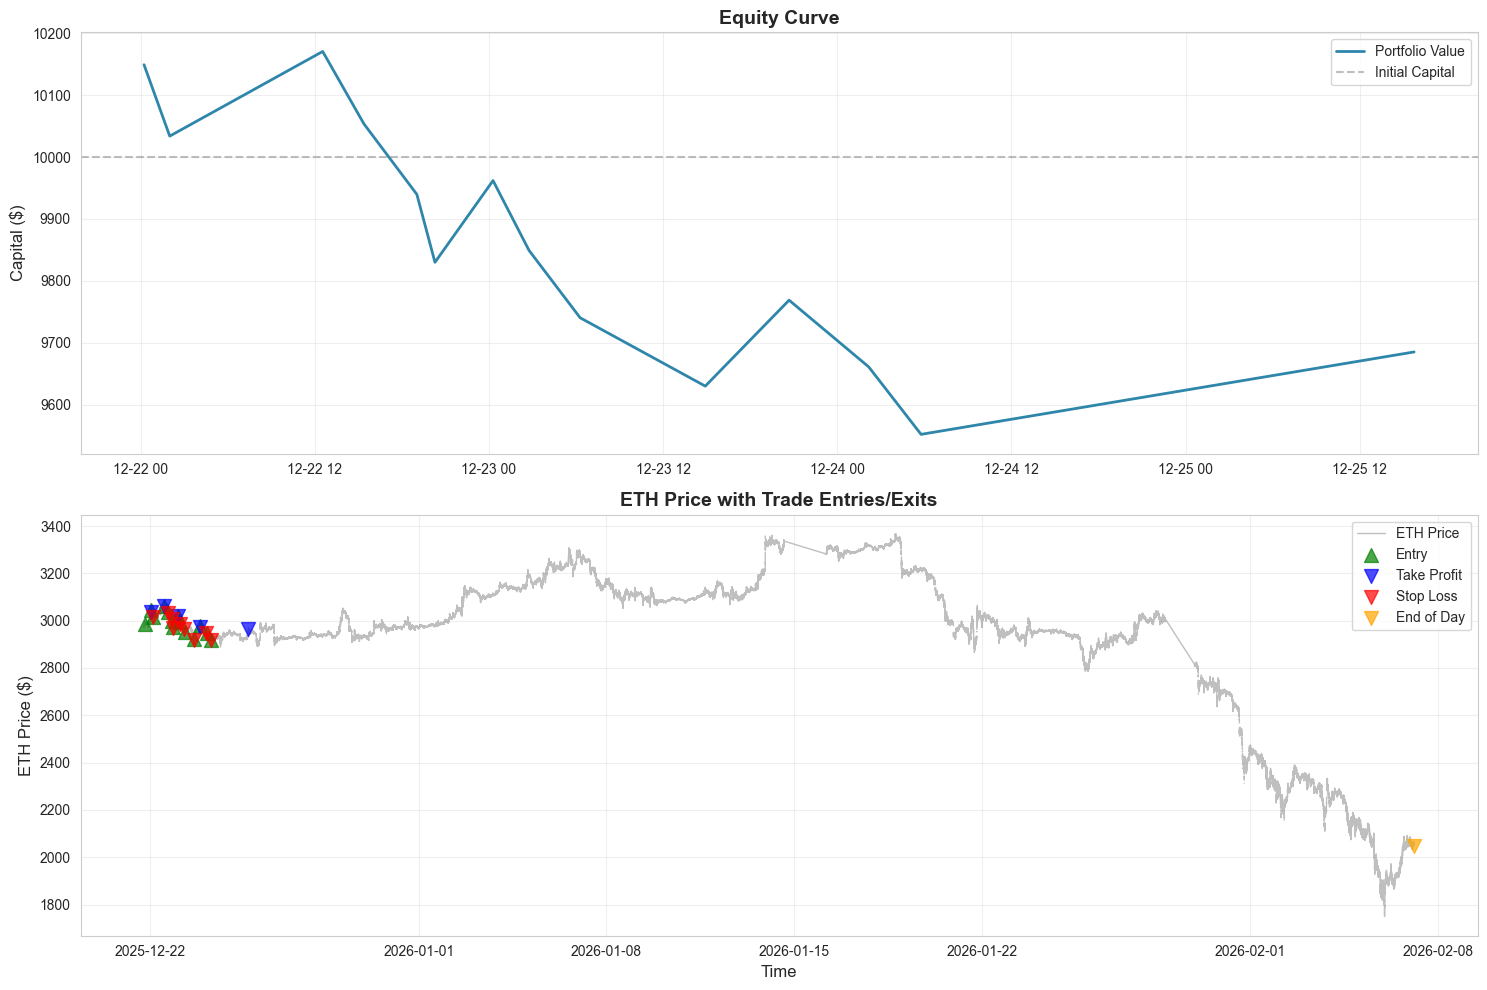

In [27]:
engine.plot_results(metrics)

---

# Trade Analysis

## 19. Examine Individual Trades

In [28]:
trades_df = metrics['trades_df']

# Display first few trades
print("📋 Sample Trades:")
trades_df

📋 Sample Trades:


,entry_time,entry_price,exit_time,exit_price,exit_reason,pnl,return_pct,duration,ml_prob,had_ML_Model,had_ADX,had_VWAP,had_RSI,had_L2_Imbalance
0,2025-12-21 18:46:02.451663,2983.995,2025-12-22 00:14:31.601620,3035.690,TP,149.247198,1.569767,0 days 05:28:29.149957,0.512820,True,True,True,True,False
1,2025-12-22 00:15:02.192146,3046.325,2025-12-22 02:00:44.351906,3014.740,SL,-115.315129,-1.195038,0 days 01:45:42.159760,0.522170,True,True,True,False,False
2,2025-12-22 02:01:04.331796,3015.380,2025-12-22 12:32:58.885664,3063.500,TP,136.743932,1.433395,0 days 10:31:54.553868,0.517262,True,True,True,False,False
3,2025-12-22 12:33:03.821613,3063.500,2025-12-22 15:23:18.991088,3031.295,SL,-116.951301,-1.209440,0 days 02:50:15.169475,0.513600,True,False,True,True,False
4,2025-12-22 15:31:04.015826,3037.865,2025-12-22 19:02:11.581866,3006.450,SL,-113.971313,-1.192333,0 days 03:31:07.566040,0.517262,True,False,True,False,False
5,2025-12-22 19:08:01.599504,2998.795,2025-12-22 20:17:03.694370,2968.705,SL,-109.781624,-1.161671,0 days 01:09:02.094866,0.517262,True,True,False,False,False
6,2025-12-22 20:30:03.733824,2972.275,2025-12-23 00:17:03.632111,3019.100,TP,132.058363,1.413002,0 days 03:46:59.898287,0.517262,True,True,False,True,False
7,2025-12-23 00:18:04.067228,3018.825,2025-12-23 02:46:01.890126,2987.600,SL,-112.953442,-1.192561,0 days 02:27:57.822898,0.518174,True,True,False,False,False
8,2025-12-23 02:50:02.002909,2994.995,2025-12-23 06:17:01.770860,2964.960,SL,-108.727463,-1.161109,0 days 03:26:59.767951,0.519375,True,True,False,False,False
9,2025-12-23 06:32:01.436723,2950.370,2025-12-23 14:54:22.050696,2919.840,SL,-110.480861,-1.193003,0 days 08:22:20.613973,0.517275,True,True,False,False,False


## 20. Trade Distribution Analysis


📊 Exit Reason Distribution:
exit_reason
SL     9
TP     5
EOD    1
Name: count, dtype: int64


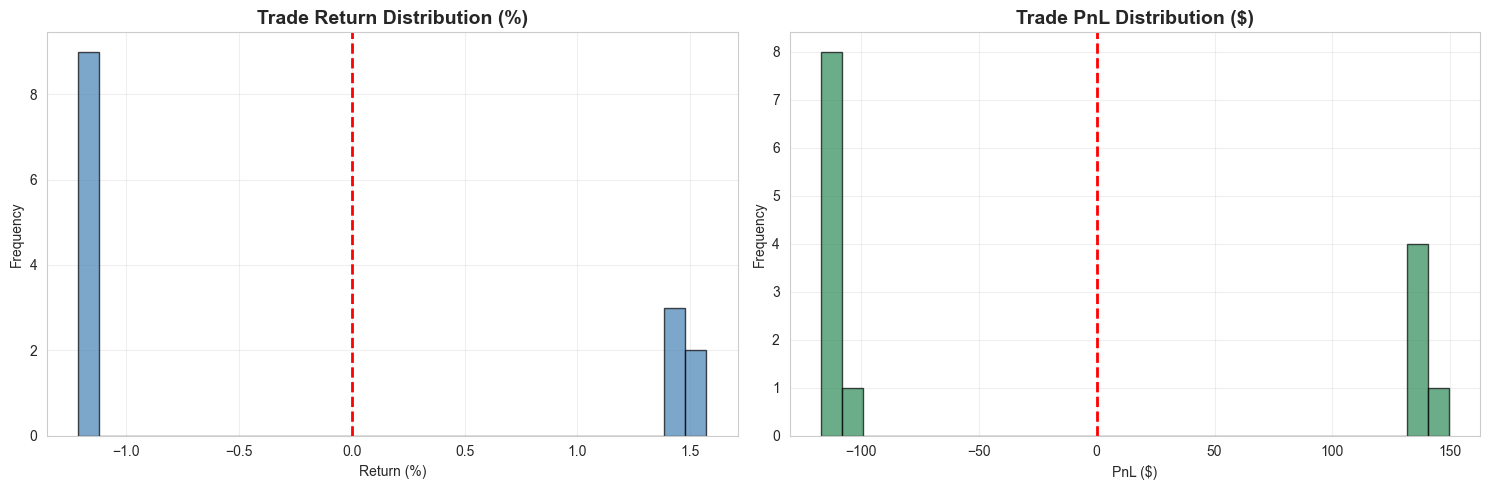

In [29]:
# Trade distribution by exit reason
print("\n📊 Exit Reason Distribution:")
print(trades_df['exit_reason'].value_counts())

# PnL distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(trades_df['return_pct'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Trade Return Distribution (%)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Return (%)')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

axes[1].hist(trades_df['pnl'], bins=30, color='seagreen', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Trade PnL Distribution ($)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PnL ($)')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 21. Indicator Participation Analysis

Which indicators contributed to each trade?

📊 Indicator Participation in Trades:

ML Model        |   15 trades | 100.0% participation
ADX             |   13 trades |  86.7% participation
VWAP            |    5 trades |  33.3% participation
RSI             |    3 trades |  20.0% participation
L2 Imbalance    |    0 trades |   0.0% participation


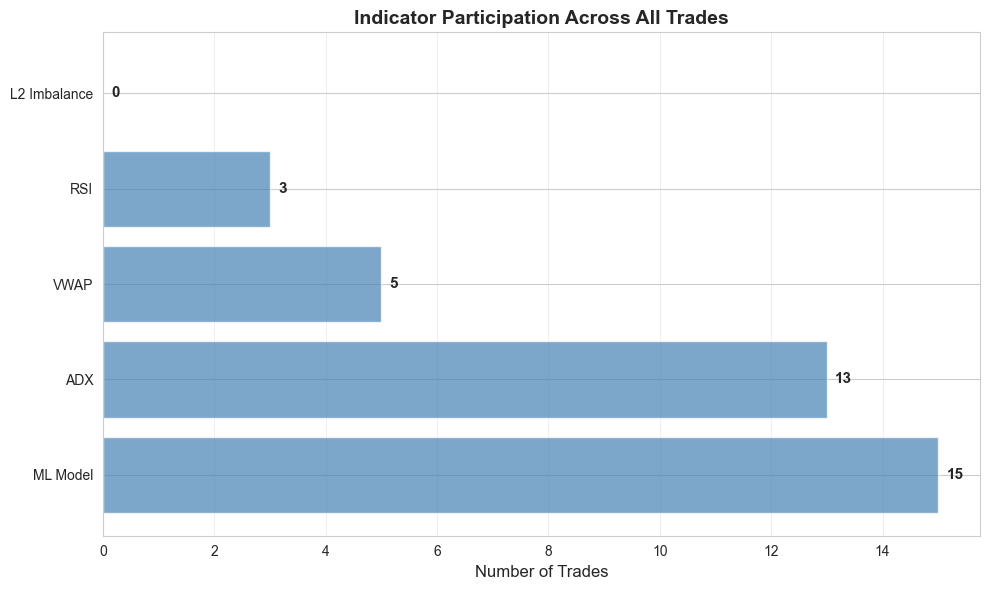

In [30]:
# Count trades by indicator participation
indicator_cols = ['had_ML_Model', 'had_ADX', 'had_VWAP', 'had_RSI', 'had_L2_Imbalance']
indicator_names = ['ML Model', 'ADX', 'VWAP', 'RSI', 'L2 Imbalance']

print("📊 Indicator Participation in Trades:\n")
print("=" * 60)

participation_counts = {}
for col, name in zip(indicator_cols, indicator_names):
    if col in trades_df.columns:
        count = trades_df[col].sum()
        pct = (count / len(trades_df)) * 100
        participation_counts[name] = count
        print(f"{name:15} | {count:4d} trades | {pct:5.1f}% participation")

print("=" * 60)

# Visualize indicator participation
fig, ax = plt.subplots(figsize=(10, 6))
indicators = list(participation_counts.keys())
counts = list(participation_counts.values())

bars = ax.barh(indicators, counts, color='steelblue', alpha=0.7)
ax.set_xlabel('Number of Trades', fontsize=12)
ax.set_title('Indicator Participation Across All Trades', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add count labels
for i, (indicator, count) in enumerate(zip(indicators, counts)):
    ax.text(count + max(counts) * 0.01, i, f'{count}', 
            va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 22. Indicator Success Rate Analysis

Which indicators correlate with profitable trades?

In [31]:
# Calculate win rates by indicator presence
print("📈 Indicator Win Rates:\n")
print("=" * 80)
print(f"{'Indicator':<15} | {'Total':>6} | {'Wins':>6} | {'Losses':>6} | {'Win Rate':>8} | {'Avg PnL':>10}")
print("=" * 80)

for col, name in zip(indicator_cols, indicator_names):
    if col in trades_df.columns:
        # Trades with this indicator
        with_indicator = trades_df[trades_df[col] == True]
        
        if len(with_indicator) > 0:
            wins = len(with_indicator[with_indicator['pnl'] > 0])
            losses = len(with_indicator[with_indicator['pnl'] <= 0])
            win_rate = (wins / len(with_indicator)) * 100
            avg_pnl = with_indicator['pnl'].mean()
            
            print(f"{name:<15} | {len(with_indicator):>6} | {wins:>6} | {losses:>6} | "
                  f"{win_rate:>7.1f}% | ${avg_pnl:>9.2f}")

print("=" * 80)
print(f"{'Overall':<15} | {len(trades_df):>6} | "
      f"{len(trades_df[trades_df['pnl'] > 0]):>6} | "
      f"{len(trades_df[trades_df['pnl'] <= 0]):>6} | "
      f"{(len(trades_df[trades_df['pnl'] > 0]) / len(trades_df) * 100):>7.1f}% | "
      f"${trades_df['pnl'].mean():>9.2f}")
print("=" * 80)

📈 Indicator Win Rates:

Indicator       |  Total |   Wins | Losses | Win Rate |    Avg PnL
ML Model        |     15 |      5 |      9 |    33.3% | $   -22.49
ADX             |     13 |      5 |      7 |    38.5% | $    -7.00
VWAP            |      5 |      2 |      3 |    40.0% | $   -12.05
RSI             |      3 |      2 |      1 |    66.7% | $    54.78
Overall         |     15 |      5 |      9 |    33.3% | $   -22.49


## 23. Indicator-Exit Outcome Correlation

Which indicators predict Take Profit vs Stop Loss?

In [32]:
# Create binary exit outcome columns
trades_df['is_TP'] = (trades_df['exit_reason'] == 'TP').astype(int)
trades_df['is_SL'] = (trades_df['exit_reason'] == 'SL').astype(int)

# Check if there's any variance in outcomes
if trades_df['is_TP'].std() == 0 or trades_df['is_SL'].std() == 0:
    print("⚠️  Warning: All trades have the same exit outcome. Correlation cannot be calculated.")
    print(f"   TP: {trades_df['is_TP'].sum()}, SL: {trades_df['is_SL'].sum()}")

# Calculate correlation matrix
correlation_data = []

for col, name in zip(indicator_cols, indicator_names):
    if col in trades_df.columns:
        # Convert boolean to int for correlation
        indicator_values = trades_df[col].astype(int)
        
        # Check for variance in indicator values
        if indicator_values.std() == 0:
            # No variance - indicator is always present or always absent
            corr_tp = 0.0
            corr_sl = 0.0
        else:
            # Calculate correlations only if there's variance in outcomes
            if trades_df['is_TP'].std() > 0:
                corr_tp = indicator_values.corr(trades_df['is_TP'])
            else:
                corr_tp = 0.0
                
            if trades_df['is_SL'].std() > 0:
                corr_sl = indicator_values.corr(trades_df['is_SL'])
            else:
                corr_sl = 0.0
        
        correlation_data.append({
            'Indicator': name,
            'TP_Correlation': corr_tp,
            'SL_Correlation': corr_sl
        })

corr_df = pd.DataFrame(correlation_data)

# Display correlation table
print("🔗 Indicator-Outcome Correlations:\n")
print("=" * 70)
print(f"{'Indicator':<15} | {'TP Correlation':>15} | {'SL Correlation':>15}")
print("=" * 70)

for _, row in corr_df.iterrows():
    tp_sign = "+" if row['TP_Correlation'] > 0 else ""
    sl_sign = "+" if row['SL_Correlation'] > 0 else ""
    print(f"{row['Indicator']:<15} | {tp_sign}{row['TP_Correlation']:>14.3f} | "
          f"{sl_sign}{row['SL_Correlation']:>14.3f}")

print("=" * 70)
print("\nInterpretation:")
print("  • Positive TP correlation = indicator predicts successful trades")
print("  • Negative SL correlation = indicator helps avoid stop losses")
print("  • Values closer to 0 = weaker relationship")

🔗 Indicator-Outcome Correlations:

Indicator       |  TP Correlation |  SL Correlation
ML Model        |          0.000 |          0.000
ADX             | +         0.277 |         -0.320
VWAP            | +         0.100 | +         0.000
RSI             | +         0.354 |         -0.272
L2 Imbalance    |          0.000 |          0.000

Interpretation:
  • Positive TP correlation = indicator predicts successful trades
  • Negative SL correlation = indicator helps avoid stop losses
  • Values closer to 0 = weaker relationship


## 24. Visual Correlation Heatmap

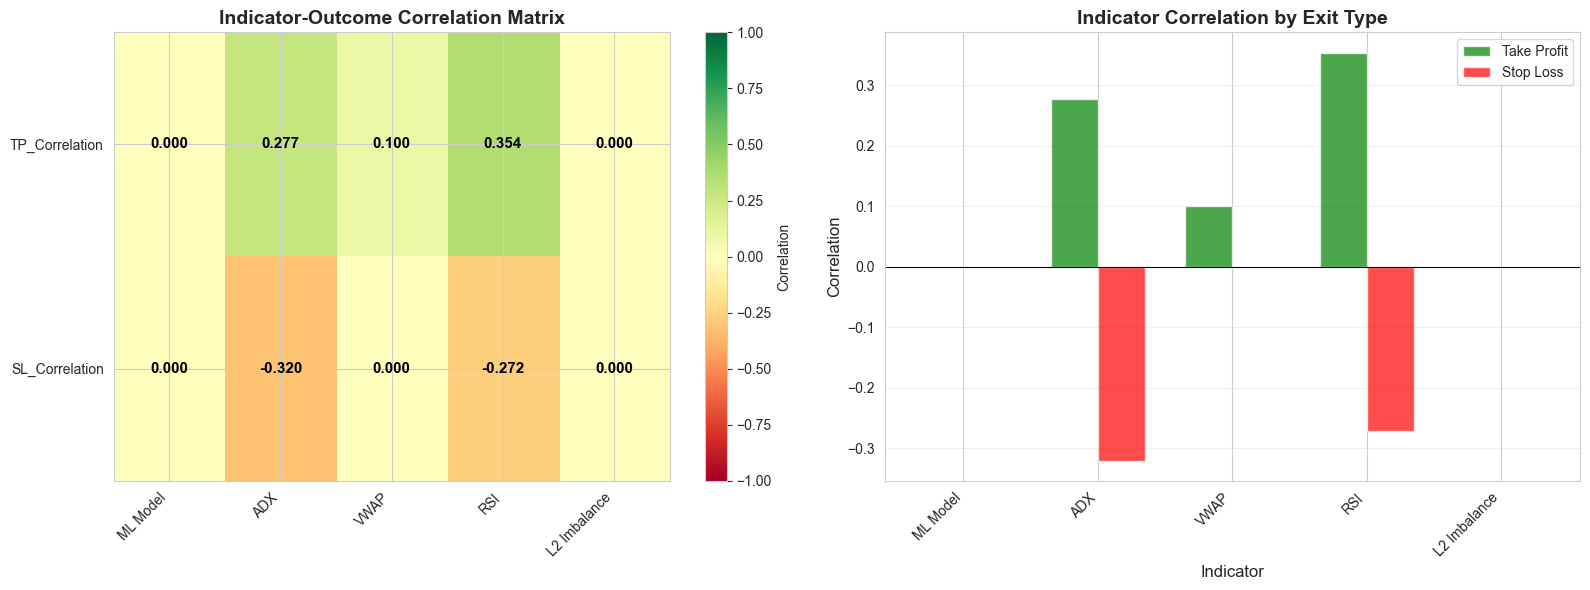

In [33]:
# Create correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for heatmap
heatmap_data = corr_df.set_index('Indicator')[['TP_Correlation', 'SL_Correlation']].T

# Plot 1: Correlation Heatmap
im1 = axes[0].imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
axes[0].set_xticks(range(len(heatmap_data.columns)))
axes[0].set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
axes[0].set_yticks(range(len(heatmap_data.index)))
axes[0].set_yticklabels(heatmap_data.index)
axes[0].set_title('Indicator-Outcome Correlation Matrix', fontsize=14, fontweight='bold')

# Add correlation values as text
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        text = axes[0].text(j, i, f'{heatmap_data.values[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=11, fontweight='bold')

plt.colorbar(im1, ax=axes[0], label='Correlation')

# Plot 2: Grouped Bar Chart
x = np.arange(len(corr_df))
width = 0.35

bars1 = axes[1].bar(x - width/2, corr_df['TP_Correlation'], width, 
                     label='Take Profit', color='green', alpha=0.7)
bars2 = axes[1].bar(x + width/2, corr_df['SL_Correlation'], width, 
                     label='Stop Loss', color='red', alpha=0.7)

axes[1].set_xlabel('Indicator', fontsize=12)
axes[1].set_ylabel('Correlation', fontsize=12)
axes[1].set_title('Indicator Correlation by Exit Type', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(corr_df['Indicator'], rotation=45, ha='right')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 25. Indicator Combination Analysis

What combinations of indicators work best?

In [34]:
# Analyze top indicator combinations
from collections import Counter

# Create indicator combination string for each trade
def get_indicator_combo(row):
    indicators = []
    for col, name in zip(indicator_cols, indicator_names):
        if col in row.index and row[col]:
            indicators.append(name.split()[0])  # Use first word for brevity
    return ' + '.join(sorted(indicators)) if indicators else 'None'

trades_df['indicator_combo'] = trades_df.apply(get_indicator_combo, axis=1)

# Count combinations
combo_stats = trades_df.groupby('indicator_combo').agg({
    'pnl': ['count', 'mean', 'sum'],
    'exit_reason': lambda x: (x == 'TP').sum()  # Count TPs
}).round(2)

combo_stats.columns = ['Total_Trades', 'Avg_PnL', 'Total_PnL', 'TP_Count']
combo_stats['Win_Rate'] = (combo_stats['TP_Count'] / combo_stats['Total_Trades'] * 100).round(1)
combo_stats = combo_stats.sort_values('Total_Trades', ascending=False)

print("🎯 Top Indicator Combinations:\n")
print("=" * 95)
print(f"{'Combination':<25} | {'Trades':>7} | {'Win Rate':>9} | {'Avg PnL':>10} | {'Total PnL':>12}")
print("=" * 95)

for combo, row in combo_stats.head(10).iterrows():
    print(f"{combo:<25} | {int(row['Total_Trades']):>7} | "
          f"{row['Win_Rate']:>8.1f}% | ${row['Avg_PnL']:>9.2f} | ${row['Total_PnL']:>11.2f}")

print("=" * 95)

🎯 Top Indicator Combinations:

Combination               |  Trades |  Win Rate |    Avg PnL |    Total PnL
ADX + ML                  |       8 |     25.0% | $   -48.34 | $    -386.72
ADX + ML + VWAP           |       2 |     50.0% | $    10.71 | $      21.43
ADX + ML + RSI            |       1 |    100.0% | $   132.06 | $     132.06
ADX + ML + RSI + VWAP     |       1 |    100.0% | $   149.25 | $     149.25
ML + RSI + VWAP           |       1 |      0.0% | $  -116.95 | $    -116.95
ML + VWAP                 |       1 |      0.0% | $  -113.97 | $    -113.97


## 26. ML Model Precision/Recall Analysis

Evaluate the ML model's prediction quality on:
1. **All Predictions**: Every time the model made a prediction (shows true model performance)
2. **Trades Only**: Only predictions that passed the committee filter (shows trading performance)

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score

# ==================== PART 1: ALL PREDICTIONS ====================
print("="*80)
print("PART 1: ALL ML MODEL PREDICTIONS (True Model Performance)")
print("="*80)

if len(engine.all_predictions) == 0:
    print("⚠️  No predictions found. ML model may not be working.")
else:
    # Convert to DataFrame
    all_preds_df = pd.DataFrame(engine.all_predictions)
    
    y_true_all = all_preds_df['actual_up']
    y_pred_all = all_preds_df['predicted_up']
    
    # Calculate metrics
    accuracy_all = accuracy_score(y_true_all, y_pred_all)
    precision_all = precision_score(y_true_all, y_pred_all, zero_division=0)
    recall_all = recall_score(y_true_all, y_pred_all, zero_division=0)
    f1_all = f1_score(y_true_all, y_pred_all, zero_division=0)
    
    # Confusion Matrix
    cm_all = confusion_matrix(y_true_all, y_pred_all)
    
    print(f"\n📊 Total Predictions: {len(all_preds_df):,}")
    print(f"   Traded: {all_preds_df['traded'].sum():,}")
    print(f"   Not Traded: {(~all_preds_df['traded']).sum():,}")
    print(f"\n{'='*80}")
    print("METRICS (All Predictions)")
    print(f"{'='*80}")
    print(f"Accuracy:   {accuracy_all:.3f}  (Overall correctness)")
    print(f"Precision:  {precision_all:.3f}  (When model predicts UP, how often is it right?)")
    print(f"Recall:     {recall_all:.3f}  (Of all UP moves, how many did model catch?)")
    print(f"F1-Score:   {f1_all:.3f}  (Harmonic mean of precision and recall)")
    print(f"{'='*80}")
    
    print("\n📋 Classification Report (All Predictions):\n")
    print(classification_report(y_true_all, y_pred_all, 
                                target_names=['Down', 'Up'],
                                zero_division=0))
    
    print("\n🔢 Confusion Matrix (All Predictions):")
    print(f"\n                 Predicted")
    print(f"              Down      Up")
    print(f"Actual Down   {cm_all[0,0]:4d}    {cm_all[0,1]:4d}")
    print(f"       Up     {cm_all[1,0]:4d}    {cm_all[1,1]:4d}")

# ==================== PART 2: TRADES ONLY ====================
print("\n" + "="*80)
print("PART 2: TRADES ONLY (Committee-Filtered Performance)")
print("="*80)

# Filter trades with ML model predictions
trades_with_ml = trades_df[trades_df['ml_prob'].notna()].copy()

if len(trades_with_ml) == 0:
    print("⚠️  No trades with ML model predictions found.")
else:
    # Create binary labels for trades
    trades_with_ml['predicted_up'] = (trades_with_ml['ml_prob'] > ML_MODEL_PROB_THRESHOLD).astype(int)
    trades_with_ml['actual_up'] = (trades_with_ml['exit_reason'] == 'TP').astype(int)
    
    y_true_trades = trades_with_ml['actual_up']
    y_pred_trades = trades_with_ml['predicted_up']
    
    # Calculate metrics
    if len(y_true_trades.unique()) >= 2 and len(y_pred_trades.unique()) >= 2:
        accuracy_trades = accuracy_score(y_true_trades, y_pred_trades)
        precision_trades = precision_score(y_true_trades, y_pred_trades, zero_division=0)
        recall_trades = recall_score(y_true_trades, y_pred_trades, zero_division=0)
        f1_trades = f1_score(y_true_trades, y_pred_trades, zero_division=0)
        cm_trades = confusion_matrix(y_true_trades, y_pred_trades)
        
        print(f"\n📊 Total Trades: {len(trades_with_ml):,}")
        print(f"\n{'='*80}")
        print("METRICS (Trades Only)")
        print(f"{'='*80}")
        print(f"Accuracy:   {accuracy_trades:.3f}  (Overall correctness)")
        print(f"Precision:  {precision_trades:.3f}  (When model predicts profit, how often is it right?)")
        print(f"Recall:     {recall_trades:.3f}  (Of all profitable trades, how many did model catch?)")
        print(f"F1-Score:   {f1_trades:.3f}  (Harmonic mean of precision and recall)")
        print(f"{'='*80}")
        
        print("\n📋 Classification Report (Trades Only):\n")
        print(classification_report(y_true_trades, y_pred_trades, 
                                    target_names=['Loss (SL)', 'Profit (TP)'],
                                    zero_division=0))
        
        print("\n🔢 Confusion Matrix (Trades Only):")
        print(f"\n                 Predicted")
        print(f"              Loss    Profit")
        print(f"Actual Loss   {cm_trades[0,0]:4d}    {cm_trades[0,1]:4d}")
        print(f"       Profit {cm_trades[1,0]:4d}    {cm_trades[1,1]:4d}")
    else:
        print("⚠️  Not enough variety in trade outcomes to calculate metrics")

# ==================== COMPARISON ====================
if len(engine.all_predictions) > 0 and len(trades_with_ml) > 0:
    print("\n" + "="*80)
    print("COMPARISON: All Predictions vs Trades Only")
    print("="*80)
    print(f"{'Metric':<15} | {'All Predictions':>17} | {'Trades Only':>17} | {'Difference':>12}")
    print("="*80)
    if len(y_true_trades.unique()) >= 2 and len(y_pred_trades.unique()) >= 2:
        print(f"{'Accuracy':<15} | {accuracy_all:>17.3f} | {accuracy_trades:>17.3f} | {accuracy_trades - accuracy_all:>+12.3f}")
        print(f"{'Precision':<15} | {precision_all:>17.3f} | {precision_trades:>17.3f} | {precision_trades - precision_all:>+12.3f}")
        print(f"{'Recall':<15} | {recall_all:>17.3f} | {recall_trades:>17.3f} | {recall_trades - recall_all:>+12.3f}")
        print(f"{'F1-Score':<15} | {f1_all:>17.3f} | {f1_trades:>17.3f} | {f1_trades - f1_all:>+12.3f}")
        print("="*80)
        print("\n💡 Interpretation:")
        print("   • Positive difference = Committee filter improves metric")
        print("   • Negative difference = Committee filter hurts metric")
        print("   • Large positive = Committee successfully filters bad predictions")

PART 1: ALL ML MODEL PREDICTIONS (True Model Performance)

📊 Total Predictions: 82
   Traded: 15
   Not Traded: 67

METRICS (All Predictions)
Accuracy:   0.476  (Overall correctness)
Precision:  0.424  (When model predicts UP, how often is it right?)
Recall:     0.848  (Of all UP moves, how many did model catch?)
F1-Score:   0.566  (Harmonic mean of precision and recall)

📋 Classification Report (All Predictions):

              precision    recall  f1-score   support

        Down       0.69      0.22      0.34        49
          Up       0.42      0.85      0.57        33

    accuracy                           0.48        82
   macro avg       0.56      0.54      0.45        82
weighted avg       0.58      0.48      0.43        82


🔢 Confusion Matrix (All Predictions):

                 Predicted
              Down      Up
Actual Down     11      38
       Up        5      28

PART 2: TRADES ONLY (Committee-Filtered Performance)
⚠️  Not enough variety in trade outcomes to calculat

## 27. Confusion Matrix Visualization

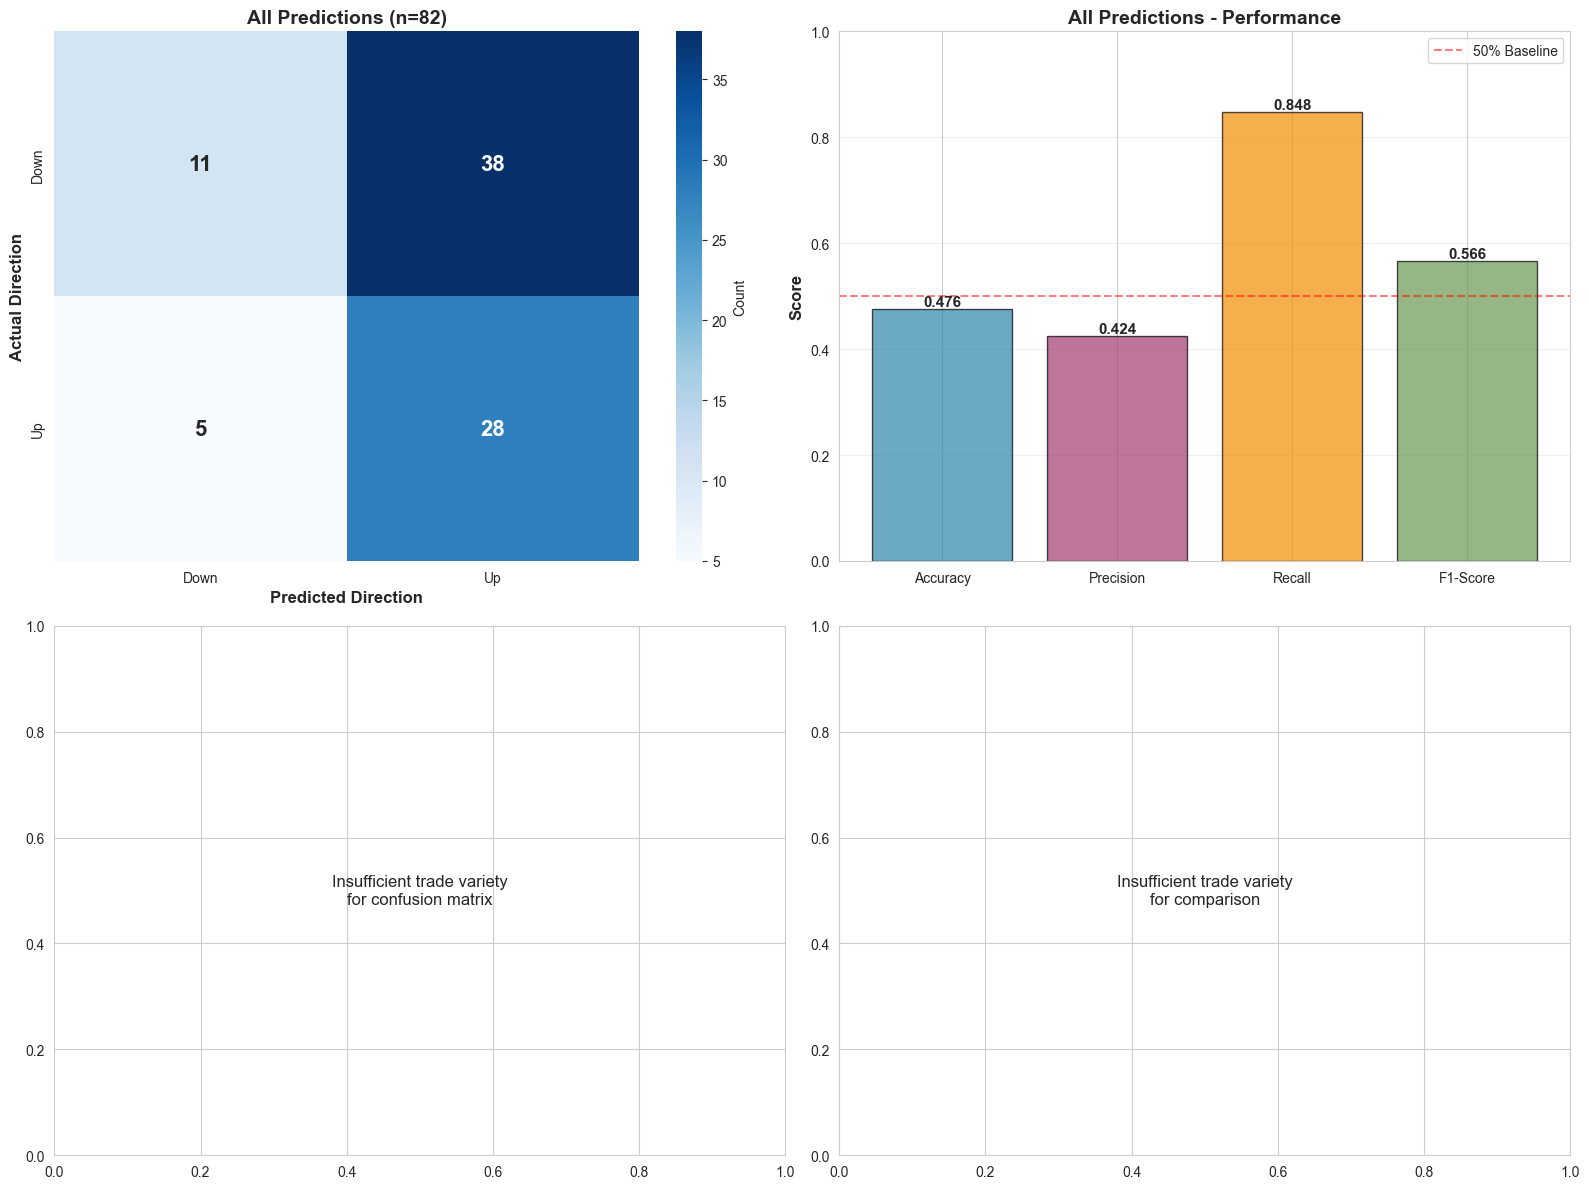


💡 Key Insights:
   • Top row shows raw ML model performance on ALL predictions
   • Bottom row shows performance only on trades that passed committee filter
   • If committee improves metrics → filter is working well
   • If committee hurts metrics → filter may be too restrictive


In [36]:
if len(engine.all_predictions) > 0:
    all_preds_df = pd.DataFrame(engine.all_predictions)
    y_true_all = all_preds_df['actual_up']
    y_pred_all = all_preds_df['predicted_up']
    cm_all = confusion_matrix(y_true_all, y_pred_all)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # ===== ROW 1: ALL PREDICTIONS =====
    
    # Plot 1: Confusion Matrix (All Predictions)
    sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Down', 'Up'],
                yticklabels=['Down', 'Up'],
                cbar_kws={'label': 'Count'},
                ax=axes[0, 0],
                annot_kws={'size': 16, 'weight': 'bold'})
    
    axes[0, 0].set_xlabel('Predicted Direction', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Actual Direction', fontsize=12, fontweight='bold')
    axes[0, 0].set_title(f'All Predictions (n={len(all_preds_df):,})', 
                         fontsize=14, fontweight='bold')
    
    # Plot 2: Metrics (All Predictions)
    accuracy_all = accuracy_score(y_true_all, y_pred_all)
    precision_all = precision_score(y_true_all, y_pred_all, zero_division=0)
    recall_all = recall_score(y_true_all, y_pred_all, zero_division=0)
    f1_all = f1_score(y_true_all, y_pred_all, zero_division=0)
    
    metrics_all = {
        'Accuracy': accuracy_all,
        'Precision': precision_all,
        'Recall': recall_all,
        'F1-Score': f1_all
    }
    
    bars = axes[0, 1].bar(metrics_all.keys(), metrics_all.values(), 
                          color=['#2E86AB', '#A23B72', '#F18F01', '#6A994E'], 
                          alpha=0.7, edgecolor='black')
    
    axes[0, 1].set_ylim(0, 1.0)
    axes[0, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('All Predictions - Performance', fontsize=14, fontweight='bold')
    axes[0, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% Baseline')
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].legend()
    
    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # ===== ROW 2: TRADES ONLY =====
    
    if len(trades_with_ml) > 0 and 'actual_up' in trades_with_ml.columns:
        y_true_trades = trades_with_ml['actual_up']
        y_pred_trades = trades_with_ml['predicted_up']
        
        if len(y_true_trades.unique()) >= 2 and len(y_pred_trades.unique()) >= 2:
            cm_trades = confusion_matrix(y_true_trades, y_pred_trades)
            
            # Plot 3: Confusion Matrix (Trades Only)
            sns.heatmap(cm_trades, annot=True, fmt='d', cmap='Greens', 
                        xticklabels=['Loss', 'Profit'],
                        yticklabels=['Loss', 'Profit'],
                        cbar_kws={'label': 'Count'},
                        ax=axes[1, 0],
                        annot_kws={'size': 16, 'weight': 'bold'})
            
            axes[1, 0].set_xlabel('Predicted Outcome', fontsize=12, fontweight='bold')
            axes[1, 0].set_ylabel('Actual Outcome', fontsize=12, fontweight='bold')
            axes[1, 0].set_title(f'Trades Only (n={len(trades_with_ml):,})', 
                                fontsize=14, fontweight='bold')
            
            # Plot 4: Metrics Comparison
            accuracy_trades = accuracy_score(y_true_trades, y_pred_trades)
            precision_trades = precision_score(y_true_trades, y_pred_trades, zero_division=0)
            recall_trades = recall_score(y_true_trades, y_pred_trades, zero_division=0)
            f1_trades = f1_score(y_true_trades, y_pred_trades, zero_division=0)
            
            x = np.arange(4)
            width = 0.35
            
            metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
            all_vals = [accuracy_all, precision_all, recall_all, f1_all]
            trade_vals = [accuracy_trades, precision_trades, recall_trades, f1_trades]
            
            bars1 = axes[1, 1].bar(x - width/2, all_vals, width, 
                                   label='All Predictions', color='skyblue', alpha=0.7, edgecolor='black')
            bars2 = axes[1, 1].bar(x + width/2, trade_vals, width, 
                                   label='Trades Only', color='lightgreen', alpha=0.7, edgecolor='black')
            
            axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
            axes[1, 1].set_title('Comparison: All vs Trades', fontsize=14, fontweight='bold')
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels(metrics_labels, rotation=45, ha='right')
            axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
            axes[1, 1].set_ylim(0, 1.0)
            axes[1, 1].legend()
            axes[1, 1].grid(axis='y', alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'Insufficient trade variety\nfor confusion matrix', 
                           ha='center', va='center', fontsize=12, transform=axes[1, 0].transAxes)
            axes[1, 1].text(0.5, 0.5, 'Insufficient trade variety\nfor comparison', 
                           ha='center', va='center', fontsize=12, transform=axes[1, 1].transAxes)
    else:
        axes[1, 0].text(0.5, 0.5, 'No trades with ML predictions', 
                       ha='center', va='center', fontsize=12, transform=axes[1, 0].transAxes)
        axes[1, 1].text(0.5, 0.5, 'No trades with ML predictions', 
                       ha='center', va='center', fontsize=12, transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Key Insights:")
    print("   • Top row shows raw ML model performance on ALL predictions")
    print("   • Bottom row shows performance only on trades that passed committee filter")
    print("   • If committee improves metrics → filter is working well")
    print("   • If committee hurts metrics → filter may be too restrictive")
else:
    print("⚠️  No predictions to visualize")

## 28. Precision-Recall Curve

Shows how precision and recall trade off at different probability thresholds.

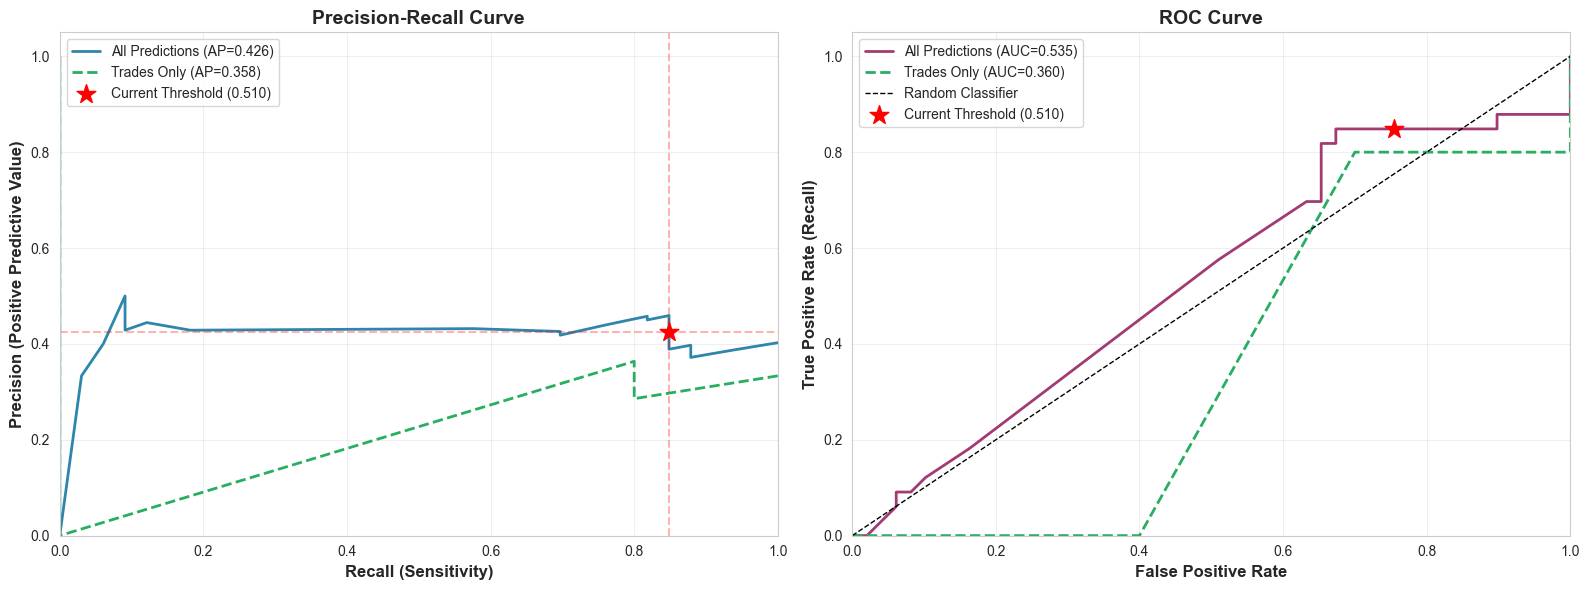


📊 Curve Analysis:
Average Precision (All):  0.426
Average Precision (Trades): 0.358
ROC AUC (All):            0.535
ROC AUC (Trades):         0.360


In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

if len(engine.all_predictions) > 0:
    all_preds_df = pd.DataFrame(engine.all_predictions)
    y_true_all = all_preds_df['actual_up']
    probs_all = all_preds_df['ml_prob']
    
    if len(y_true_all.unique()) >= 2:
        # Calculate curves for ALL predictions
        precisions_all, recalls_all, thresholds_pr_all = precision_recall_curve(y_true_all, probs_all)
        avg_precision_all = average_precision_score(y_true_all, probs_all)
        fpr_all, tpr_all, thresholds_roc_all = roc_curve(y_true_all, probs_all)
        roc_auc_all = auc(fpr_all, tpr_all)
        
        # Calculate current threshold metrics
        y_pred_all = (probs_all > ML_MODEL_PROB_THRESHOLD).astype(int)
        precision_all = precision_score(y_true_all, y_pred_all, zero_division=0)
        recall_all = recall_score(y_true_all, y_pred_all, zero_division=0)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Precision-Recall Curve
        axes[0].plot(recalls_all, precisions_all, linewidth=2, color='#2E86AB', 
                    label=f'All Predictions (AP={avg_precision_all:.3f})')
        
        # Add trades-only curve if available
        if len(trades_with_ml) > 0 and 'actual_up' in trades_with_ml.columns:
            y_true_trades = trades_with_ml['actual_up']
            probs_trades = trades_with_ml['ml_prob']
            
            if len(y_true_trades.unique()) >= 2:
                precisions_trades, recalls_trades, _ = precision_recall_curve(y_true_trades, probs_trades)
                avg_precision_trades = average_precision_score(y_true_trades, probs_trades)
                axes[0].plot(recalls_trades, precisions_trades, linewidth=2, color='#27AE60', 
                           label=f'Trades Only (AP={avg_precision_trades:.3f})', linestyle='--')
        
        axes[0].scatter([recall_all], [precision_all], color='red', s=200, zorder=5, 
                       label=f'Current Threshold ({ML_MODEL_PROB_THRESHOLD:.3f})', marker='*')
        axes[0].axhline(y=precision_all, color='red', linestyle='--', alpha=0.3)
        axes[0].axvline(x=recall_all, color='red', linestyle='--', alpha=0.3)
        
        axes[0].set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Precision (Positive Predictive Value)', fontsize=12, fontweight='bold')
        axes[0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].grid(alpha=0.3)
        axes[0].legend(loc='best')
        
        # Plot 2: ROC Curve
        axes[1].plot(fpr_all, tpr_all, linewidth=2, color='#A23B72', 
                    label=f'All Predictions (AUC={roc_auc_all:.3f})')
        
        # Add trades-only curve if available
        if len(trades_with_ml) > 0 and 'actual_up' in trades_with_ml.columns and len(y_true_trades.unique()) >= 2:
            fpr_trades, tpr_trades, _ = roc_curve(y_true_trades, probs_trades)
            roc_auc_trades = auc(fpr_trades, tpr_trades)
            axes[1].plot(fpr_trades, tpr_trades, linewidth=2, color='#27AE60', 
                        label=f'Trades Only (AUC={roc_auc_trades:.3f})', linestyle='--')
        
        axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        
        # Find point closest to current threshold
        idx = (np.abs(thresholds_roc_all - ML_MODEL_PROB_THRESHOLD)).argmin()
        axes[1].scatter([fpr_all[idx]], [tpr_all[idx]], color='red', s=200, zorder=5,
                       label=f'Current Threshold ({ML_MODEL_PROB_THRESHOLD:.3f})', marker='*')
        
        axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
        axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].grid(alpha=0.3)
        axes[1].legend(loc='best')
        
        plt.tight_layout()
        plt.show()
        
        print("\n📊 Curve Analysis:")
        print("=" * 70)
        print(f"Average Precision (All):  {avg_precision_all:.3f}")
        if len(trades_with_ml) > 0 and 'actual_up' in trades_with_ml.columns and len(y_true_trades.unique()) >= 2:
            print(f"Average Precision (Trades): {avg_precision_trades:.3f}")
        print(f"ROC AUC (All):            {roc_auc_all:.3f}")
        if len(trades_with_ml) > 0 and 'actual_up' in trades_with_ml.columns and len(y_true_trades.unique()) >= 2:
            print(f"ROC AUC (Trades):         {roc_auc_trades:.3f}")
        print("=" * 70)
        
    else:
        print("⚠️  Cannot plot curves - insufficient outcome variety")
else:
    print("⚠️  No predictions to analyze")

## 29. Probability Distribution Analysis

Compare probability distributions for profitable vs unprofitable trades.

C:\Users\mattr\AppData\Local\Temp\ipykernel_18664\2901739285.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(box_data, labels=['Actually Up', 'Actually Down'],


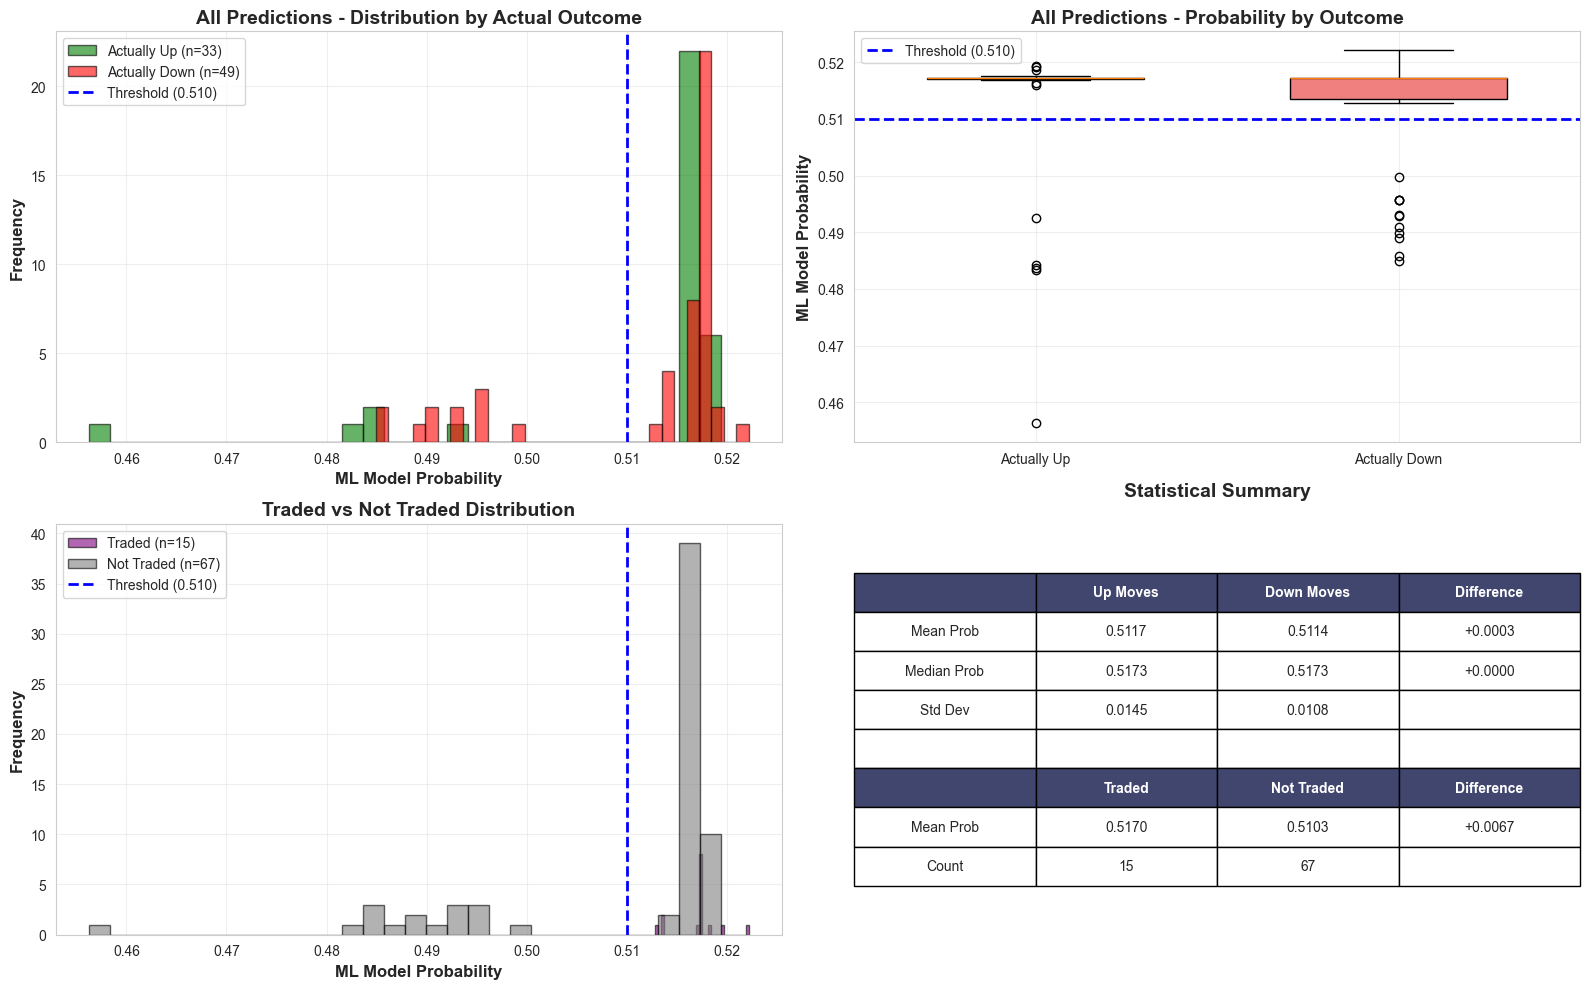


💡 Key Insights:
Mean Probability Difference: +0.0003
   ⚙️  Weak discrimination - model struggles to separate up/down moves

Trade Filter Effectiveness:
   • 15 predictions were traded (18.3%)
   • 67 predictions were filtered out (81.7%)
   • Traded predictions have mean prob: 0.5170
   • Non-traded predictions have mean prob: 0.5103


In [38]:
if len(engine.all_predictions) > 0:
    all_preds_df = pd.DataFrame(engine.all_predictions)
    
    # Separate by actual outcome
    profitable = all_preds_df[all_preds_df['actual_up'] == 1]
    unprofitable = all_preds_df[all_preds_df['actual_up'] == 0]
    
    # Further separate by whether they were traded
    traded = all_preds_df[all_preds_df['traded'] == True]
    not_traded = all_preds_df[all_preds_df['traded'] == False]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Overlapping Histograms (All Predictions)
    axes[0, 0].hist(profitable['ml_prob'], bins=30, alpha=0.6, color='green', 
                   label=f'Actually Up (n={len(profitable):,})', edgecolor='black')
    axes[0, 0].hist(unprofitable['ml_prob'], bins=30, alpha=0.6, color='red', 
                   label=f'Actually Down (n={len(unprofitable):,})', edgecolor='black')
    axes[0, 0].axvline(x=ML_MODEL_PROB_THRESHOLD, color='blue', linestyle='--', 
                      linewidth=2, label=f'Threshold ({ML_MODEL_PROB_THRESHOLD:.3f})')
    axes[0, 0].set_xlabel('ML Model Probability', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('All Predictions - Distribution by Actual Outcome', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Box Plot Comparison (All Predictions)
    box_data = [profitable['ml_prob'].dropna(), unprofitable['ml_prob'].dropna()]
    bp = axes[0, 1].boxplot(box_data, labels=['Actually Up', 'Actually Down'], 
                            patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    axes[0, 1].axhline(y=ML_MODEL_PROB_THRESHOLD, color='blue', linestyle='--', 
                      linewidth=2, label=f'Threshold ({ML_MODEL_PROB_THRESHOLD:.3f})')
    axes[0, 1].set_ylabel('ML Model Probability', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('All Predictions - Probability by Outcome', fontsize=14, fontweight='bold')
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].legend()
    
    # Plot 3: Traded vs Not Traded
    axes[1, 0].hist(traded['ml_prob'], bins=30, alpha=0.6, color='purple', 
                   label=f'Traded (n={len(traded):,})', edgecolor='black')
    axes[1, 0].hist(not_traded['ml_prob'], bins=30, alpha=0.6, color='gray', 
                   label=f'Not Traded (n={len(not_traded):,})', edgecolor='black')
    axes[1, 0].axvline(x=ML_MODEL_PROB_THRESHOLD, color='blue', linestyle='--', 
                      linewidth=2, label=f'Threshold ({ML_MODEL_PROB_THRESHOLD:.3f})')
    axes[1, 0].set_xlabel('ML Model Probability', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Traded vs Not Traded Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Plot 4: Statistical Summary Table
    axes[1, 1].axis('off')
    
    stats_data = [
        ['', 'Up Moves', 'Down Moves', 'Difference'],
        ['Mean Prob', f"{profitable['ml_prob'].mean():.4f}", 
         f"{unprofitable['ml_prob'].mean():.4f}",
         f"{profitable['ml_prob'].mean() - unprofitable['ml_prob'].mean():+.4f}"],
        ['Median Prob', f"{profitable['ml_prob'].median():.4f}", 
         f"{unprofitable['ml_prob'].median():.4f}",
         f"{profitable['ml_prob'].median() - unprofitable['ml_prob'].median():+.4f}"],
        ['Std Dev', f"{profitable['ml_prob'].std():.4f}", 
         f"{unprofitable['ml_prob'].std():.4f}", ''],
        ['', '', '', ''],
        ['', 'Traded', 'Not Traded', 'Difference'],
        ['Mean Prob', f"{traded['ml_prob'].mean():.4f}", 
         f"{not_traded['ml_prob'].mean():.4f}",
         f"{traded['ml_prob'].mean() - not_traded['ml_prob'].mean():+.4f}"],
        ['Count', f"{len(traded):,}", f"{len(not_traded):,}", ''],
    ]
    
    table = axes[1, 1].table(cellText=stats_data, cellLoc='center', loc='center',
                            colWidths=[0.25, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style header rows
    for i in [0, 5]:
        for j in range(4):
            table[(i, j)].set_facecolor('#40466e')
            table[(i, j)].set_text_props(weight='bold', color='white')
    
    axes[1, 1].set_title('Statistical Summary', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    mean_diff = profitable['ml_prob'].mean() - unprofitable['ml_prob'].mean()
    print("\n💡 Key Insights:")
    print("=" * 70)
    print(f"Mean Probability Difference: {mean_diff:+.4f}")
    if mean_diff > 0.05:
        print("   ✅ Model assigns significantly higher probabilities to up moves (good!)")
    elif mean_diff < -0.05:
        print("   ⚠️  Model assigns LOWER probabilities to up moves (concerning!)")
    else:
        print("   ⚙️  Weak discrimination - model struggles to separate up/down moves")
    
    print(f"\nTrade Filter Effectiveness:")
    print(f"   • {len(traded):,} predictions were traded ({len(traded)/len(all_preds_df)*100:.1f}%)")
    print(f"   • {len(not_traded):,} predictions were filtered out ({len(not_traded)/len(all_preds_df)*100:.1f}%)")
    print(f"   • Traded predictions have mean prob: {traded['ml_prob'].mean():.4f}")
    print(f"   • Non-traded predictions have mean prob: {not_traded['ml_prob'].mean():.4f}")
    print("=" * 70)
else:
    print("⚠️  No predictions to analyze")